# Contoh Pengolahan Data GeoJSON Menggunakan *shapely*, *geopandas*, dan *plotly* (in Python)

In [1]:
# data wrangling, inspecting and utilities modules
import pandas as pd
import numpy as np
import geopandas
# informative chart modules
import plotly.express as px
import matplotlib.pyplot as plt
# geo module
from shapely.geometry import Polygon, MultiPolygon, Point
# utilities
import random
import warnings
import json

# setting pandas options
pd.set_option('display.float', '{:,.2f}'.format)
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 75)
pd.set_option('display.max_info_columns', 50)
warnings.filterwarnings('ignore', category=DeprecationWarning)

## 1. *Low-level* Operations menggunakan `shapely`

Package *shapely* memiliki banyak tipe geometri (lihat [dokumentasi](https://shapely.readthedocs.io/en/stable/geometry.html) untuk info lebih jelasnya). Kita akan menggunakan tipe geometri yang paling sering dioperasikan menggunakan file *geojson*: `Point`, `Polygon`, dan `MultiPolygon`. Object geometry *shapely* bersifat *immutable*. 

#### **Contoh implementasi: random sampling point di dalam polygon**

Berikut adalah *polygon* DKI Jakarta (tidak termasuk kepulauan seribu). Polygon ini merupakan polygon *level 1* (administratif level *provinsi*).

![dki_jakarta_l1](img\DKI_Jakarta_LVL_1.PNG)

Kita akan membuat polygon diatas dalam bentuk object *shapely*:

In [2]:
filename = 'data\DKI_JAKARTA_lvl_1.json'
with open(filename, 'r') as f:
    poly_geojson_1 = json.load(f)
poly_coord = poly_geojson_1['features'][0]['geometry']['coordinates'][0]
poly_obj = Polygon(shell=poly_coord)

Dalam code diatas:

- Kita membaca file *geojson* menggunakan package `json`
- Koordinat polygon kita akses didalam object `json` dari tahap sebelumnya
- Kita meng-*construct* `shapely.Polygon` dengan menggunakan koordinat polygon sebagai `shell` kwags.

Kita bisa memanfaatkan *attribut* dan *method* dari object `shapely.Polygon`. Katakanlah kita mau mengecek apakah suatu titik koordinat berada di area DKI Jakarta. Kita gunakan geometri *point*, yaitu `shapely.Point`.

Mengapa perlu menggunakan `shapely.Point`? Ini karena *method* yang akan kita gunakan (`shapely.Polygon.contains`) mengharuskan kita untuk *passing* argument berupa object *shapely*.

In [3]:
coordinate = (106.91497998166815, -6.254602478608049)
p = Point(coordinate)
print(f'coordinate in DKI Jakarta: {poly_obj.contains(p)}')

coordinate in DKI Jakarta: True


Dengan menggunakan method `shapely.Polygon.contains()` kita mengeceka apakah `shapely.Point` berada di dalam polygon tersebut.

Problem di atas dapat kita kembangkan lagi, sebagai contoh: *Tentukan 100 titik sampling secara random di dalam lingkup DKI Jakarta.* 

Kode dibawah adalah contoh solusi dari problem tersebut:

In [4]:
def generate_random_points(polygon: object, num_points):
    minx, miny, maxx, maxy = polygon.bounds
    points = []
    while len(points) < num_points:
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        p = Point(x, y)
        if polygon.contains(p):
            points.append((y, x))
    return np.array(points)

# generate random points inside polygon
sampling_points = generate_random_points(poly_obj, 100)

# plot
fig = px.scatter_mapbox(
    lat=sampling_points[:, 0], lon=sampling_points[:, 1],
    color_discrete_sequence=np.repeat('red', len(sampling_points))
    )
fig.update_layout(
    title='Sampling Points',
    mapbox_style="stamen-toner",            
    autosize=True,
    hovermode='closest',
    mapbox=dict(zoom=9)
    )
fig.show(renderer='iframe')

Dalam kode diatas:

- Kita menggunakan attribute `shapely.Polygon.bound` untuk mendapatkan informasi terkait boundary polygon.
- Kita generate random point di dalam range boundary tersebut
- Kita cek, apakah titik tersebut berada di dalam polygon? Jika tidak, kita generate ulang titiknya sampai jumlah titik yang didapat sesuai

Dapat kita lihat bahwa semua titik berada di dalam lingkup administratif DKI Jakarta.

#### **Multipolygon**

`shapely.MultiPolygon` adalah object untuk menyimpan deretan *Polygon*.

In [5]:
filename = 'data\DKI_JAKARTA_lvl_3.json'
with open(filename, 'r') as f:
    poly_geojson_3 = json.load(f)
districts = {}
for feature in poly_geojson_3['features']:
    districts[feature['properties']['NAME_3']] = Polygon(feature['geometry']['coordinates'][0][0])

poly_districs = MultiPolygon([values for values in districts.values()])

Kita bisa mengakses object di dalam *MultiPolygon*:

In [6]:
print(f'Luas area: {poly_districs.geoms[1].area}')
coordinate = (106.91497998166815, -6.254602478608049)
p = Point(coordinate)
print(f'Coordinate in geoms: {poly_districs.geoms[1].contains(p)}')

Luas area: 0.0008776349999998809
Coordinate in geoms: False


## 2. Implementasi `geopandas`

Package `geopandas` adalah kombinasi antara `pandas` dan `shapely` sebagai package untuk mengoperasikan geometric object. Object utamanya yaitu `GeoDataFrame`.

#### **Membuat GeoDataFrame dengan Membaca GeoJSON**

Kita bisa membuat `GeoDataFrame` menggunakan `geopandas.read_file`:

In [7]:
jakarta_gdf = geopandas.read_file('data\DKI_JAKARTA_lvl_3.json')
jakarta_gdf = jakarta_gdf.rename(
    columns={
        'COUNTRY': 'country', 
        'NAME_1': 'province', 
        'NAME_2': 'city',
        'NAME_3': 'district'}
    )
jakarta_gdf = jakarta_gdf[['country', 'province', 'city', 'district', 'geometry']]
jakarta_gdf.head()
        

,country,province,city,district,geometry
0,Indonesia,JakartaRaya,JakartaBarat,Cengkareng,"MULTIPOLYGON (((106.70850 -6.18110, 106.70040 ..."
1,Indonesia,JakartaRaya,JakartaBarat,Grogolpetamburan,"MULTIPOLYGON (((106.79450 -6.15270, 106.79940 ..."
2,Indonesia,JakartaRaya,JakartaBarat,Kalideres,"MULTIPOLYGON (((106.68870 -6.17120, 106.69000 ..."
3,Indonesia,JakartaRaya,JakartaBarat,Kebonjeruk,"MULTIPOLYGON (((106.78270 -6.20260, 106.78350 ..."
4,Indonesia,JakartaRaya,JakartaBarat,Kembangan,"MULTIPOLYGON (((106.72020 -6.22420, 106.71760 ..."


Dari *GeoDataFrame* diatas kita dapat setiap *features* dari GeoJSON DKI Jakarta level 3. Kolom `geometry` menyimpan object `shapely`:

<class 'shapely.geometry.multipolygon.MultiPolygon'>


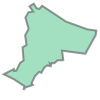

In [8]:
sample = jakarta_gdf.geometry[0]
print(type(sample))
sample

#### **Operasi yang Melibatkan GeoPandas**

GeoPandas mempunyai *tools* untuk mengolah GeoDataFrame (satu atau lebih). Dalam contoh kali ini, kita akan menggabungkan dua *GeoDataFrame* menggunakan `geopandas.sjoin`.

Di dalam repository ini terdapat data yang berisi *jarak dari suatu titik (lat, long) terhadap fasilitas publik terdekat (dalam contoh ini adalah rumah sakit)*. Dataset ini berisi *records*  berikut:

![sampling](img\Contoh_hasil_sampling.PNG)

Kita akan meng-construct satu *GeoDataFrame* menggunakan dataset ini!

In [9]:
sampling_df = pd.read_csv('data\dki_data_akses_hospital.csv')
sampling_df.head()

,waktu,tag,lat,long,tag_tujuan,tujuan_terdekat,durasi_tempuh,durasi_tempuh_unit,jarak_tempuh,jarak_tempuh_unit,rute
0,2023-02-06_13-04,mengemudi,-6.25,106.91,hospital,"Harum Sisma Medika Hospital, Jl. Lobi dan UGD ...",9.00,min,2.50,km,Jl. Elang Malindo
1,2023-02-06_13-04,mengemudi,-6.25,106.91,hospital,"Harum Sisma Medika Hospital, Jl. Lobi dan UGD ...",9.00,min,2.50,km,Jl. Raya Jatiwaringin
2,2023-02-06_13-04,mengemudi,-6.25,106.91,hospital,"Harum Sisma Medika Hospital, Jl. Lobi dan UGD ...",9.00,min,2.50,km,Jl. Elang Malindo V
3,2023-02-06_13-04,mengemudi,-6.25,106.91,hospital,"Harum Sisma Medika Hospital, Jl. Lobi dan UGD ...",9.00,min,2.50,km,Jl. Elang Malindo III
4,2023-02-06_13-04,mengemudi,-6.25,106.91,hospital,"Harum Sisma Medika Hospital, Jl. Lobi dan UGD ...",9.00,min,2.50,km,Jl. Wirajasa


Dapat kita lihat bahwa data tersebut dalam *long format*. Dalam satu destinasi terdapat banyak *rute* (jalan) yang dilalui dari titik ke destinasi terdekat.

Dalam contoh ini, kita tidak membutuhkan data rute ini:

In [10]:
sampling_df = sampling_df\
    .drop(columns=['rute'])\
    .drop_duplicates()\
    .reset_index(drop=True)

sampling_df.head()

,waktu,tag,lat,long,tag_tujuan,tujuan_terdekat,durasi_tempuh,durasi_tempuh_unit,jarak_tempuh,jarak_tempuh_unit
0,2023-02-06_13-04,mengemudi,-6.25,106.91,hospital,"Harum Sisma Medika Hospital, Jl. Lobi dan UGD ...",9.00,min,2.50,km
1,2023-02-06_13-05,mengemudi,-6.22,106.92,hospital,"Rumah Sakit Harapan Jayakarta, Blok KM No.18, ...",12.00,min,5.70,km
2,2023-02-06_13-06,mengemudi,-6.18,106.78,hospital,"RS Grha Kedoya, Jl. Panjang No.26, RT.15/RW.7,...",12.00,min,3.70,km
3,2023-02-06_13-07,mengemudi,-6.16,106.96,hospital,Gading Pluit Hospital,22.00,min,9.70,km
4,2023-02-06_13-07,mengemudi,-6.34,106.82,hospital,"Hospital Ali Sibroh Malisi, Jl. Wr. Sila No.1,...",6.00,min,1.50,km


Kolom `lat` dan `long` adalah 100 titik sampling yang kita dapat sebelumnya.

Sekarang kita akan convert *DataFrame* diatas menjadi *GeoDataFrame*:

In [11]:
sampling_gdf = geopandas.GeoDataFrame(data=sampling_df)
sampling_gdf.head()

,waktu,tag,lat,long,tag_tujuan,tujuan_terdekat,durasi_tempuh,durasi_tempuh_unit,jarak_tempuh,jarak_tempuh_unit
0,2023-02-06_13-04,mengemudi,-6.25,106.91,hospital,"Harum Sisma Medika Hospital, Jl. Lobi dan UGD ...",9.00,min,2.50,km
1,2023-02-06_13-05,mengemudi,-6.22,106.92,hospital,"Rumah Sakit Harapan Jayakarta, Blok KM No.18, ...",12.00,min,5.70,km
2,2023-02-06_13-06,mengemudi,-6.18,106.78,hospital,"RS Grha Kedoya, Jl. Panjang No.26, RT.15/RW.7,...",12.00,min,3.70,km
3,2023-02-06_13-07,mengemudi,-6.16,106.96,hospital,Gading Pluit Hospital,22.00,min,9.70,km
4,2023-02-06_13-07,mengemudi,-6.34,106.82,hospital,"Hospital Ali Sibroh Malisi, Jl. Wr. Sila No.1,...",6.00,min,1.50,km


*GeoDataFrame* diatas belum sepenuhnya menjadi `gdf` karena kekurangan satu data vital: `geometric spatial` data. Oleh karena itu, kita akan membuat satu kolom geometric yang mengandung *geometric* dalam format `shapely.Point`:

In [12]:
def get_point(x, y):
    return Point(x, y)

get_point_vect = np.vectorize(get_point)

sampling_gdf = sampling_gdf.assign(
    geometry=lambda x: geopandas.GeoSeries.from_xy(x.long, x.lat)
    )
sampling_gdf = geopandas.GeoDataFrame(sampling_gdf, crs=4326)

Kita akan menggabungkan kolom [`district`, `geometry`] dari `jakarta_gdf` ke dalam `sampling_gdf` dengan menggunakan codes berikut:

In [13]:
sampling_gdf_joined = \
    geopandas.sjoin(
        jakarta_gdf[['city', 'district', 'geometry']], 
        sampling_gdf,  
        how='inner', predicate='contains')

sampling_gdf_joined.head()

,city,district,geometry,index_right,waktu,tag,lat,long,tag_tujuan,tujuan_terdekat,durasi_tempuh,durasi_tempuh_unit,jarak_tempuh,jarak_tempuh_unit
0,JakartaBarat,Cengkareng,"MULTIPOLYGON (((106.70850 -6.18110, 106.70040 ...",31,2023-02-06_13-25,mengemudi,-6.18,106.71,hospital,"Klinik Citra Keluarga Medika, Jl. Raya No.74 R...",8.00,min,1.90,km
0,JakartaBarat,Cengkareng,"MULTIPOLYGON (((106.70850 -6.18110, 106.70040 ...",87,2023-02-06_14-00,mengemudi,-6.17,106.72,hospital,"Pondok Indah Hospital - Puri Indah, Jl. Puri I...",21.00,min,6.90,km
0,JakartaBarat,Cengkareng,"MULTIPOLYGON (((106.70850 -6.18110, 106.70040 ...",61,2023-02-06_13-45,mengemudi,-6.17,106.73,hospital,"Pondok Indah Hospital - Puri Indah, Jl. Puri I...",11.00,min,2.50,km
0,JakartaBarat,Cengkareng,"MULTIPOLYGON (((106.70850 -6.18110, 106.70040 ...",64,2023-02-06_13-47,mengemudi,-6.13,106.73,hospital,"Ciputra Hospital CitraGarden City, Jl. Satu Ma...",13.00,min,4.00,km
1,JakartaBarat,Grogolpetamburan,"MULTIPOLYGON (((106.79450 -6.15270, 106.79940 ...",14,2023-02-06_13-14,mengemudi,-6.16,106.78,hospital,"RS Grha Kedoya, Jl. Panjang No.26, RT.15/RW.7,...",10.00,min,3.00,km


Perhatikan bahwa kita menggunakan operasi `contains`, sama seperti *low-level operations* yang sudah dijelaskan sebelumnya. Hanya dengan menggunakan `geopandas.sjoin`, operasi ini dilakukan *row-wise* (vectorized).

#### **Contoh Output: Geospatial Plot**

Dari *GeoDataFrame* diatas, terdapat `MULTIPOLYGON` geometry. Kita bisa menggunakan dataframe diatas untuk membuat plot berdasarkan polygon tersebut, dalam contoh ini akan dihasilkan plot level *kecamatan*.

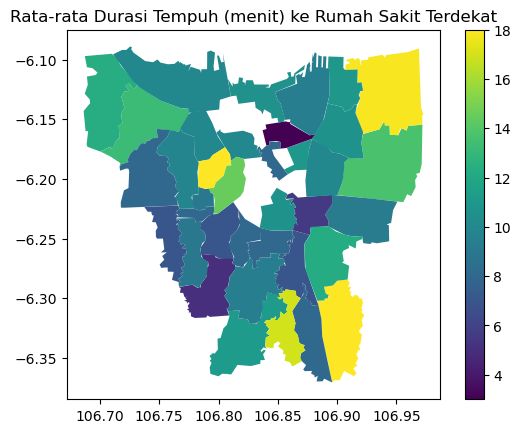

In [14]:
agg_sampling_df = sampling_gdf_joined\
    .groupby('district')\
    .agg({'durasi_tempuh': 'mean', 'geometry': lambda x: x.values[0]})\
    .reset_index()
agg_sampling_df = geopandas.GeoDataFrame(agg_sampling_df, crs=4326)
fig, ax = plt.subplots()
agg_sampling_df.plot('durasi_tempuh', legend=True, ax=ax)
ax.set_title('Rata-rata Durasi Tempuh (menit) ke Rumah Sakit Terdekat')
plt.show()

Di atas adalah contoh penggunaan `GeoDataFrame.plot()`. Dalam contoh di atas, kita melakukan aggregate *mean* untuk durasi tempuh berdasarkan `kecamatan`. Terdapat *missing records* di beberapa titik kecamatan. 

Selain menggunakan `GeoDataFrame.plot()`, kita bisa menggunakan `plotly` untuk menghasilkan plot interaktif:

In [15]:
# plot
filename = 'data\DKI_JAKARTA_lvl_3.json'
with open(filename, 'r') as f:
    poly_geojson_3 = json.load(f)
fig = px.choropleth(
    data_frame=agg_sampling_df,
    geojson=poly_geojson_3,
    locations='district',
    color='durasi_tempuh',
    featureidkey='properties.NAME_3',
    fitbounds='locations',
    basemap_visible=False,
    title='Rata-rata Durasi Tempuh (menit) ke Rumah Sakit Terdekat',
    )
fig.show(renderer='iframe')

## 3. Reference

Data GeoJSON didapat dari: [GADM](https://gadm.org/download_country.html).

Online GeoJSON editor menggunakan: [Geoman.io](https://geoman.io).